In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
sys.path.append('../src')

import csv
from utils import DEFAULT_PALETTE
from WADParser import WAD_file
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from utils import EXMY_REGEX, MAPS_ATTRS
import struct
import re
from copy import deepcopy

In [19]:
w = WAD_file('../WADs/DOOM.WAD')

2025-02-25 20:48:30.486 | INFO     | WADParser:__init__:19 - IWAD found at ../WADs/DOOM.WAD
2025-02-25 20:48:30.486 | INFO     | WADParser:_get_palette:92 - Palette extracted.
2025-02-25 20:48:30.486 | INFO     | WADParser:_parse_levels:120 - 36 levels found in this WAD.
2025-02-25 20:48:30.496 | INFO     | WADParser:_parse_by_markers:150 - 107 FLATS found in this WAD.
2025-02-25 20:48:30.496 | INFO     | WADParser:_parse_by_markers:150 - 764 SPRITES found in this WAD.


In [40]:
id2sprite = {}
with open('../src/THINGS/DOOM.csv', newline='') as csvfile:
    csvreader  = csv.reader(csvfile, delimiter=';', quotechar='|')
    header = next(csvreader)
    for row in csvreader:
        id2sprite[row[0]] = (row[5] + row[6][0])

id2sprite


{'68': 'BSPIA',
 '64': 'VILEA',
 '3003': 'BOSSA',
 '3005': 'HEADA',
 '72': 'KEENA',
 '16': 'CYBRA',
 '3002': 'SARGA',
 '65': 'CPOSA',
 '69': 'BOS2A',
 '3001': 'TROOA',
 '3006': 'SKULA',
 '67': 'FATTA',
 '71': 'PAINA',
 '66': 'SKELA',
 '9': 'SPOSA',
 '58': 'SARGA',
 '7': 'SPIDA',
 '84': 'SSWVA',
 '3004': 'POSSA',
 '2006': 'BFUGA',
 '2002': 'MGUNA',
 '2005': 'CSAWA',
 '2004': 'PLASA',
 '2003': 'LAUNA',
 '2001': 'SHOTA',
 '82': 'SGN2A',
 '2008': 'SHELA',
 '2048': 'AMMOA',
 '2046': 'BROKA',
 '2049': 'SBOXA',
 '2007': 'CLIPA',
 '2047': 'CELLA',
 '17': 'CELPA',
 '2010': 'ROCKA',
 '2015': 'BON2A',
 '2023': 'PSTRA',
 '2026': 'PMAPA',
 '2014': 'BON1A',
 '2022': 'PINVA',
 '2045': 'PVISA',
 '83': 'MEGAA',
 '2024': 'PINSA',
 '2013': 'SOULA',
 '2018': 'ARM1A',
 '8': 'BPAKA',
 '2012': 'MEDIA',
 '2019': 'ARM2A',
 '2025': 'SUITA',
 '2011': 'STIMA',
 '5': 'BKEYA',
 '40': 'BSKUA',
 '13': 'RKEYA',
 '38': 'RSKUA',
 '6': 'YKEYA',
 '39': 'YSKUA',
 '47': 'SMITA',
 '70': 'FCANA',
 '43': 'TRE1A',
 '35': 'CBRAA

In [5]:
vx_offset, vx_size = w.maps['E1M3']['VERTEXES']
w.wad.seek(vx_offset)
lump = w.wad.read(vx_size)

vertices = np.array([struct.unpack('<hh', lump[i:i+4]) for i in range(0, len(lump), 4)])
vertices.shape

(946, 2)

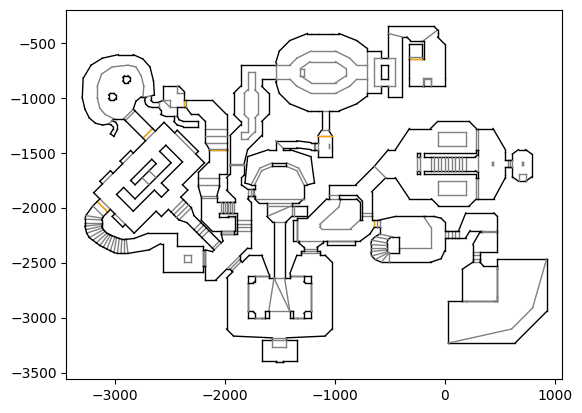

In [6]:
l_offset, l_size = w.maps['E1M3']['LINEDEFS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

linedefs = np.array([struct.unpack('<hhhhhhh', lump[i:i+14]) for i in range(0, len(lump), 14)]).astype(np.int16)

lines = vertices[linedefs[:, 0:2]]
flags = linedefs[:, 2]

for line, flag in zip(lines, flags):
    
    if flag & 0x01:  # Impassable
        plt.plot(line[:, 0], line[:, 1], color='black', linewidth=1)

    if flag & 0x04:  # Two-sided
        plt.plot(line[:, 0], line[:, 1], color='grey', linewidth=1)
    
    if flag & 0x20:  # Secret (not displayed on automap)
        plt.plot(line[:, 0], line[:, 1], color='orange', linewidth=1)

plt.axis('equal')
plt.show()      

In [130]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

In [132]:
d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
d2 = d.copy()
lines = []
idx = 0

while True:
    if len(d) == 0: break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        save_vertex = d2.get(start, None)

        if (next_vertex is None) & (save_vertex is None):
            break
        elif (next_vertex is None) & (save_vertex is not None):
            line.append(save_vertex)
            break

        line.append(next_vertex)
        start = next_vertex
    lines.append(line)


In [41]:
l_offset, l_size = w.maps['E1M3']['THINGS']
w.wad.seek(l_offset)
lump = w.wad.read(l_size)

things = np.array([struct.unpack('<hhhhh', lump[i:i+10]) for i in range(0, len(lump), 10)]).astype(np.int16)

things

array([[-1472, -3344,    90,     1,     7],
       [-1600, -3344,    90,     3,     7],
       [-1408, -3344,    90,     2,     7],
       ...,
       [  512, -1696,   270,    15,     7],
       [  384, -1472,   270,    24,     7],
       [-1088, -1216,   270,  2046,     7]], shape=(380, 5), dtype=int16)

In [45]:
things_in_map = defaultdict(list)
for thing in things:
    things_in_map[id2sprite[str(thing[3])]].append((int(thing[0]), int(thing[1])))

things_in_map



defaultdict(list,
            {'PLAYA': [(-1472, -3344),
              (-1600, -3344),
              (-1408, -3344),
              (-1536, -3344)],
             'BON1A': [(-2832, -848),
              (-2128, -1120),
              (-2128, -1184),
              (-2080, -1184),
              (-2080, -1248),
              (-80, -2160),
              (-64, -2208),
              (-2112, -1600),
              (-2064, -1600),
              (-2064, -1648),
              (-2160, -2624),
              (-2160, -2416),
              (-2000, -2256),
              (-1776, -1856),
              (-1952, -1792),
              (-2720, -1424),
              (-2752, -1456),
              (-2784, -1488),
              (-2928, -1632),
              (-2960, -1664),
              (-2992, -1696),
              (-2752, -2336),
              (-2624, -2288),
              (-2496, -2272),
              (-2496, -2368),
              (-288, -816),
              (-240, -816),
              (-608, -928),
              

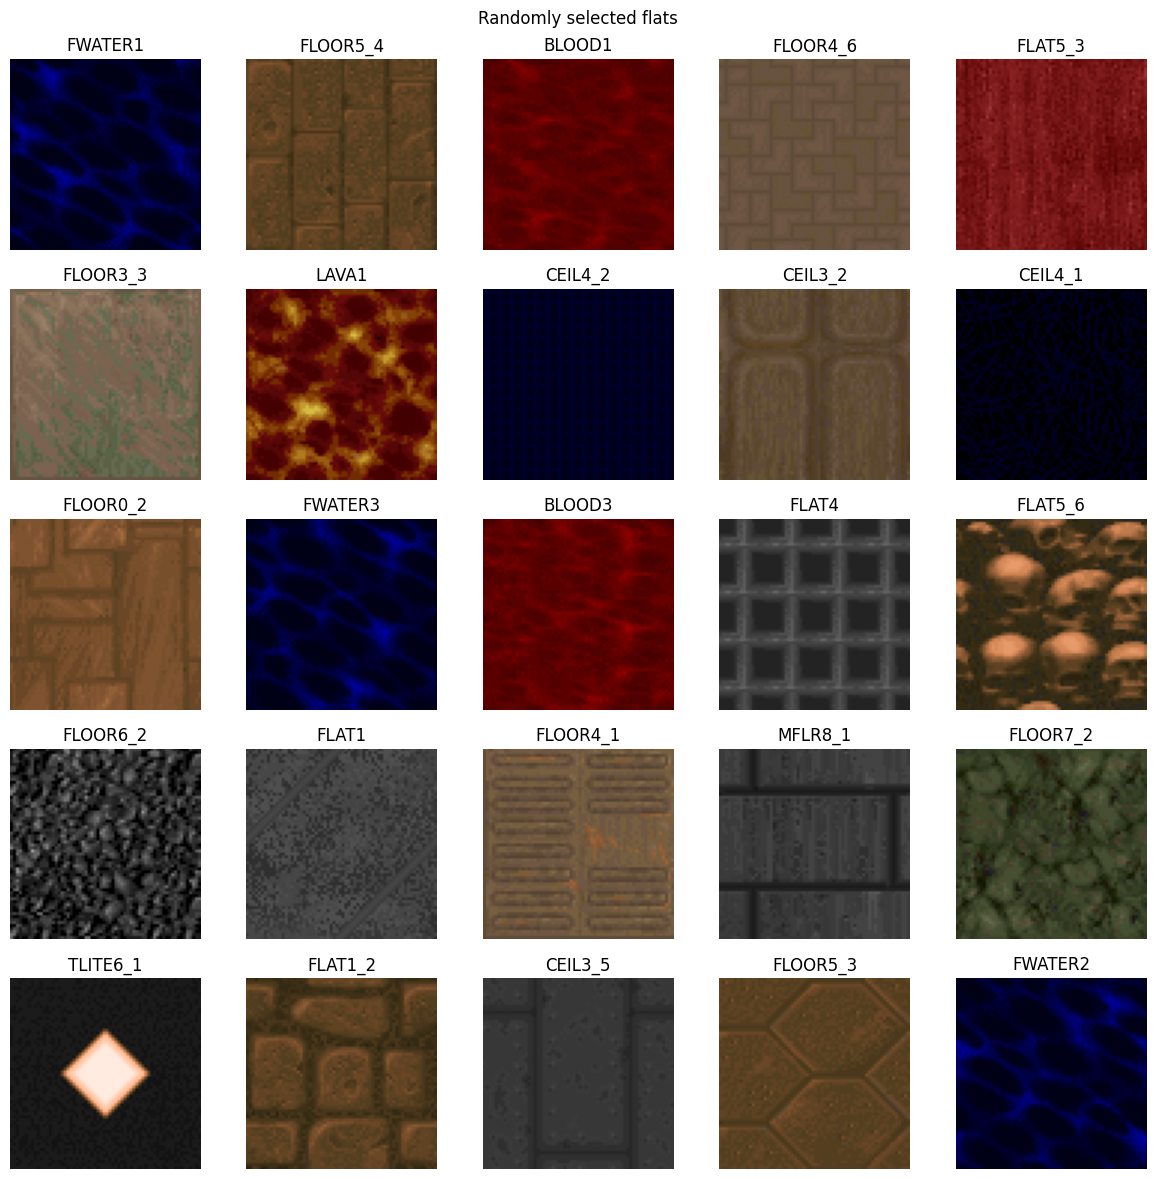

In [46]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

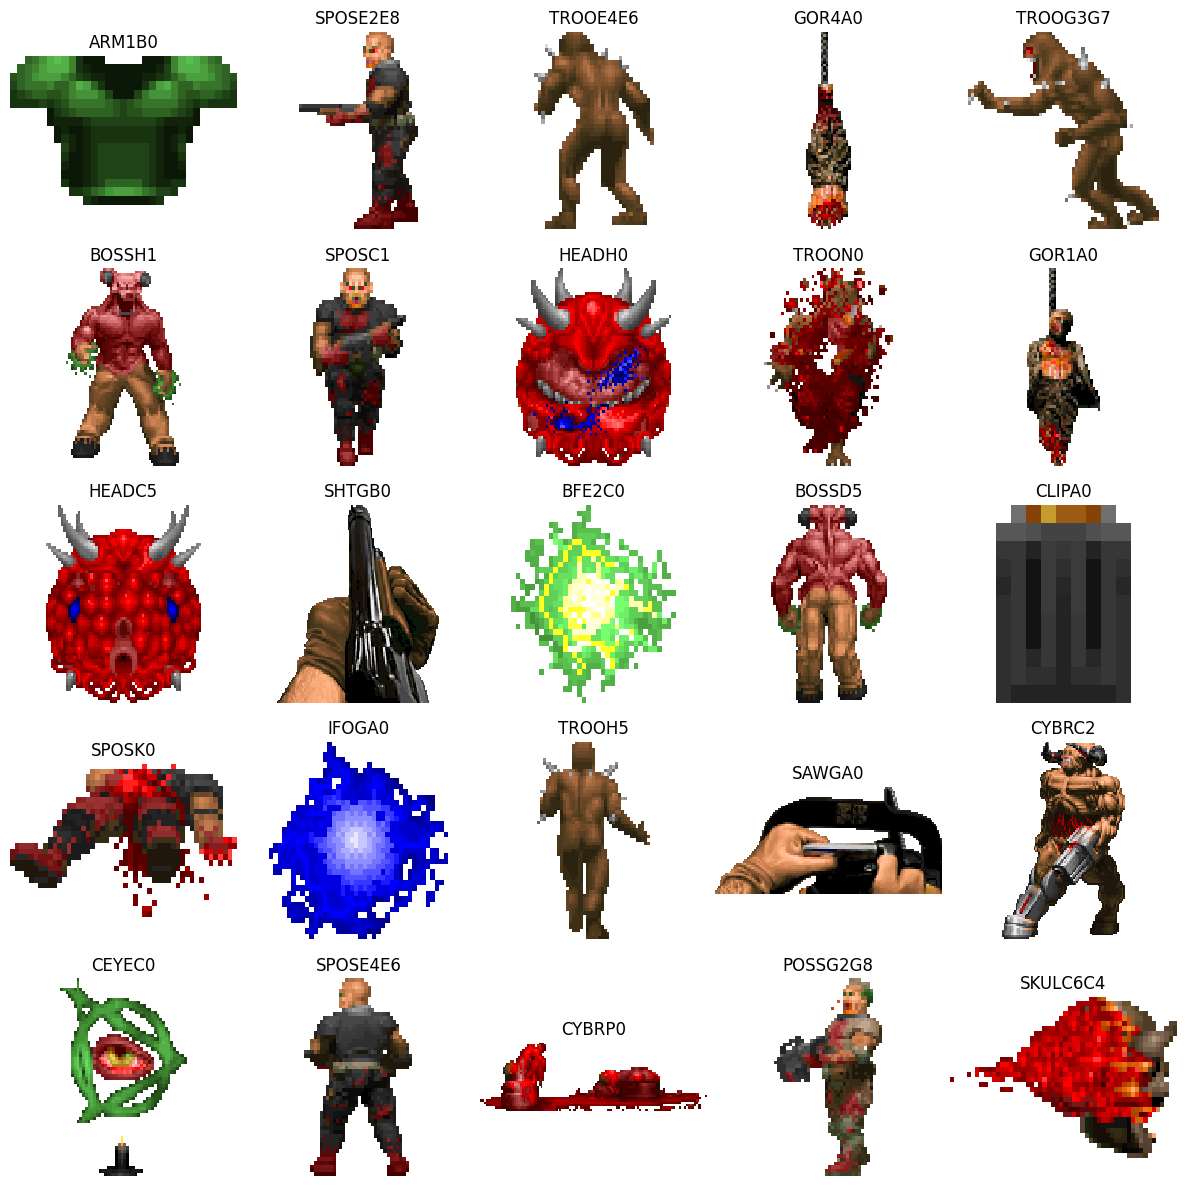

In [47]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

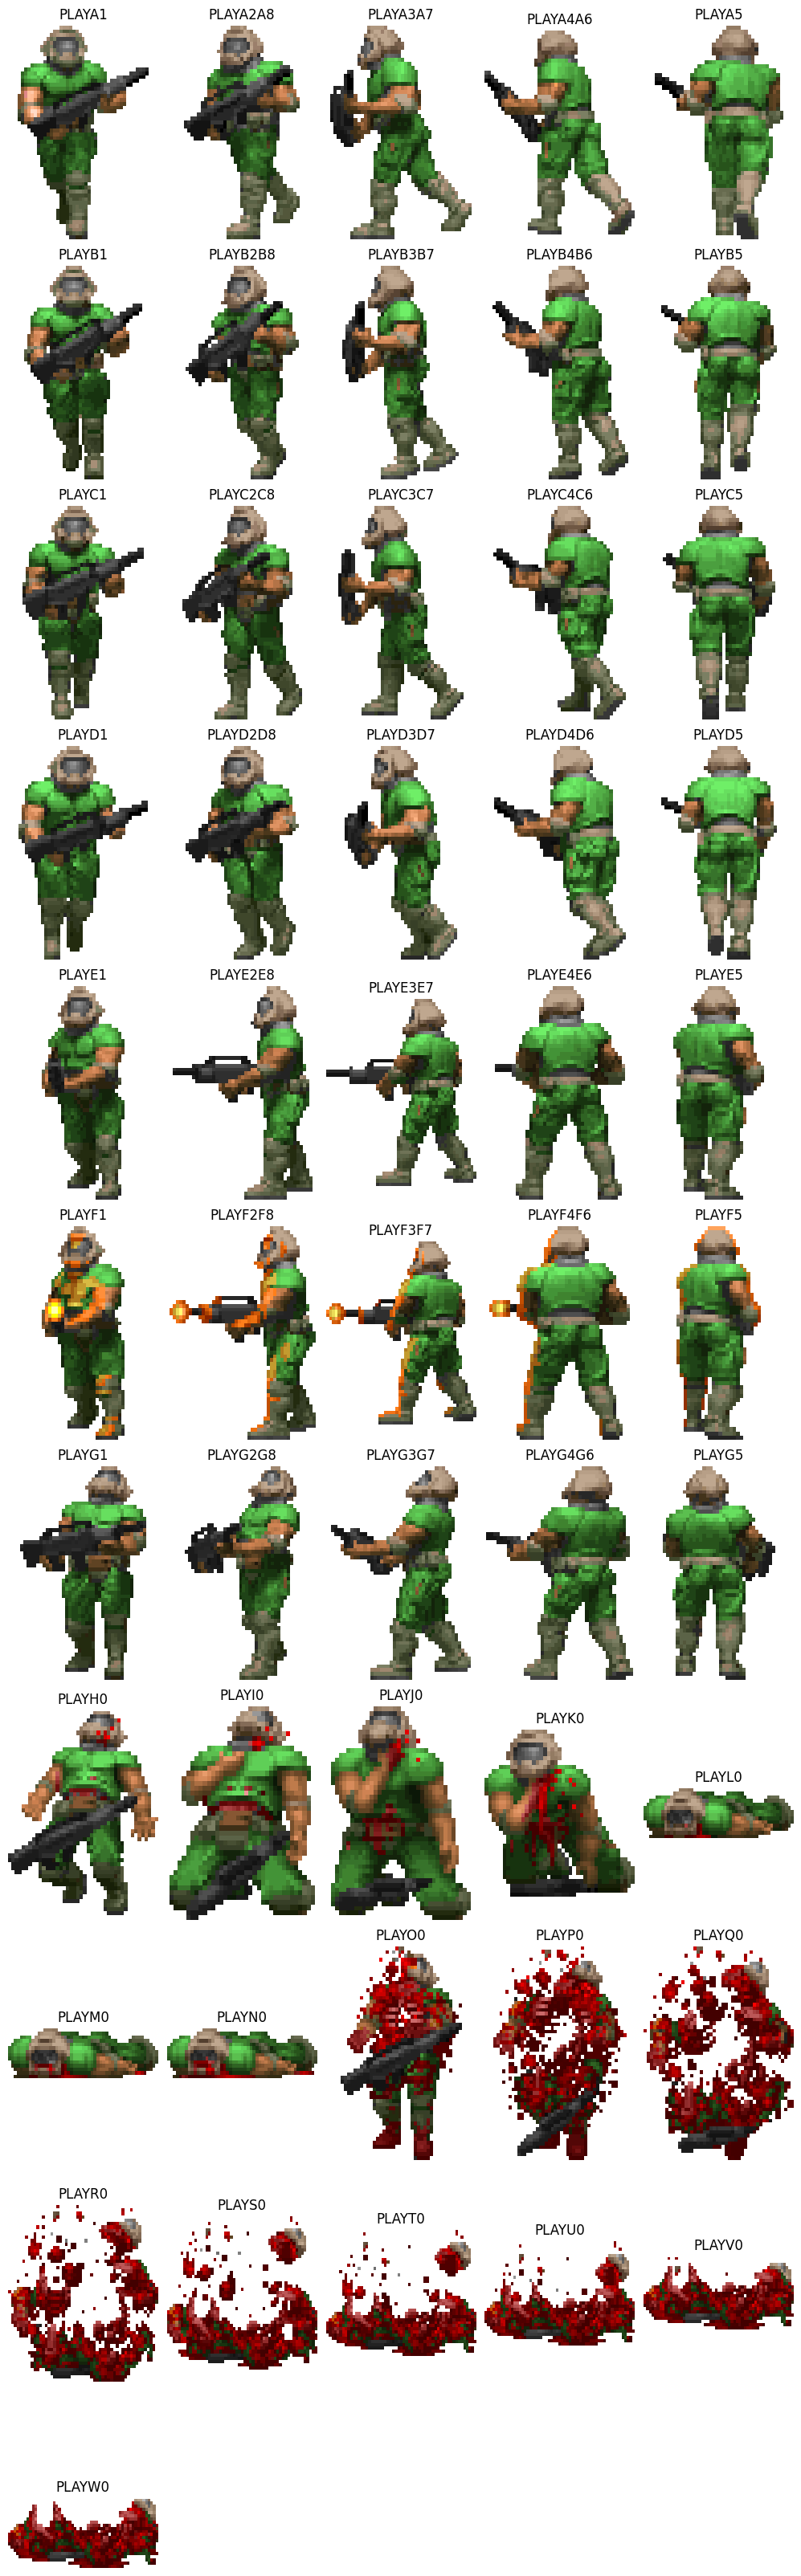

In [48]:
sprite_name = 'PLAY'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)

In [10]:
# Example linedefs array (replace this with your actual data)
linedefs = np.array([[1, 2], [2, 3], [3, 4], [4, 1]])

d = {int(k): int(v) for k, v in zip(linedefs[:, 0], linedefs[:, 1])}
lines = []
idx = 0

while True:
    if len(d) == 0:
        break
    start = next(iter(d))
    line = [start]
    while True:
        next_vertex = d.pop(start, None)
        if next_vertex is None:
            break
        line.append(next_vertex)
        start = next_vertex
    lines.append(line)

print(lines)

[[1, 2, 3, 4, 1]]
